In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr

In [ ]:
np.random.seed(42)
random.seed(42)

data = pd.read_excel('RFLFSODataFull.xlsx')
data = shuffle(data, random_state=42)

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [ ]:
data_FSO = train_data[['AbsoluteHumidity', 'Distance', 'Particulate', 'ParticulateMax', 'ParticulateMin',
                       'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'TemperatureMin',
                       'Visibility', 'VisibilityMax', 'SYNOPCode', 'FSO_Att']]

data_RFL = train_data[['AbsoluteHumidity', 'Distance', 'Frequency', 'ParticulateMax', 'RainIntensity',
                       'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode',
                       'Temperature', 'Visibility', 'RFL_Att']]

In [ ]:
synop_values = [0, 3, 4, 5, 6, 7, 8]
categories = ['clear', 'dust_storm', 'fog', 'drizzle', 'rain', 'snow', 'showers']
data_FSO = data_FSO.copy()
data_FSO['SYNOPCode_Categorical'] = pd.Categorical(data_FSO['SYNOPCode'], categories=synop_values, ordered=True)
data_FSO['SYNOPCode_Categorical'] = data_FSO['SYNOPCode_Categorical'].map(dict(zip(synop_values, categories)))
print(data_FSO[['SYNOPCode', 'SYNOPCode_Categorical']].head(7))

       SYNOPCode SYNOPCode_Categorical
1261           6                  rain
22916          4                   fog
8670           0                 clear
74811          0                 clear
28415          0                 clear
32527          0                 clear
50579          0                 clear


In [ ]:
X_rf1 = data_RFL.drop(columns=['RFL_Att'])
y_rf1 = data_RFL['RFL_Att']
rf_model_1 = RandomForestRegressor(
    max_depth=30, max_features='log2', n_estimators=273, random_state=42
)
rf_model_1.fit(X_rf1, y_rf1)
rf_att_pred_train = rf_model_1.predict(X_rf1)

In [ ]:
# Model 2: Predict FSO_Att using weather + RFL_Att prediction
X_fso = data_FSO.drop(columns=['FSO_Att','SYNOPCode_Categorical'])
X_rf2 = X_fso.copy()
X_rf2['RFL_Att_pred'] = rf_att_pred_train
y_rf2 = data_FSO['FSO_Att']
rf_model_2 = RandomForestRegressor(random_state=42)
rf_model_2.fit(X_rf2, y_rf2)

RandomForestRegressor(random_state=42)

In [ ]:
test_FSO = test_data[['AbsoluteHumidity', 'Distance', 'Particulate', 'ParticulateMax', 'ParticulateMin',
                      'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'TemperatureMin',
                      'Visibility', 'VisibilityMax', 'SYNOPCode', 'FSO_Att']]

test_RFL = test_data[['AbsoluteHumidity', 'Distance', 'Frequency', 'ParticulateMax', 'RainIntensity',
                      'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode',
                      'Temperature', 'Visibility', 'RFL_Att']]

X_rf1_test = test_RFL.drop(columns=['RFL_Att'])
y_rf1_test = test_RFL['RFL_Att']
rf_att_pred_test = rf_model_1.predict(X_rf1_test)

X_fso_test = test_FSO.drop(columns=['FSO_Att'])
X_rf2_test = X_fso_test.copy()
X_rf2_test['RFL_Att_pred'] = rf_att_pred_test
y_rf2_test = test_FSO['FSO_Att']
fso_att_pred = rf_model_2.predict(X_rf2_test)


In [ ]:
print("FSO_Att Prediction R^2:", r2_score(y_rf2_test, fso_att_pred))
print("FSO_Att Prediction MSE:", mean_squared_error(y_rf2_test, fso_att_pred))

print("RFL_Att Prediction R^2:", r2_score(y_rf1_test, rf_att_pred_test))
print("RFL_Att Prediction MSE:", mean_squared_error(y_rf1_test, rf_att_pred_test))

FSO_Att Prediction R^2: 0.9354250815915695
FSO_Att Prediction MSE: 0.9828731988954803
RFL_Att Prediction R^2: 0.972129305907683
RFL_Att Prediction MSE: 0.32924835664318763


# Method 3

In [ ]:
synop_values = [0, 3, 4, 5, 6, 7, 8]
categories = ['clear', 'dust_storm', 'fog', 'drizzle', 'rain', 'snow', 'showers']
data_RFL = data_RFL.copy()
data_RFL['SYNOPCode_Categorical'] = pd.Categorical(data_RFL['SYNOPCode'], categories=synop_values, ordered=True)
data_RFL['SYNOPCode_Categorical'] = data_RFL['SYNOPCode_Categorical'].map(dict(zip(synop_values, categories)))
print(data_RFL[['SYNOPCode', 'SYNOPCode_Categorical']].head(7))

       SYNOPCode SYNOPCode_Categorical
1261           6                  rain
22916          4                   fog
8670           0                 clear
74811          0                 clear
28415          0                 clear
32527          0                 clear
50579          0                 clear


In [ ]:
X_fso1 = data_FSO.drop(columns=['FSO_Att','SYNOPCode_Categorical'])
y_fso1 = data_FSO['FSO_Att']

fso_model_1 = RandomForestRegressor(
    max_depth=30, max_features='log2', n_estimators=273, random_state=42
)
fso_model_1.fit(X_fso1, y_fso1)
fso_att_pred_train = fso_model_1.predict(X_fso1)

In [ ]:
X_rfl = data_RFL.drop(columns=['RFL_Att','SYNOPCode_Categorical'])
X_rfl2 = X_rfl.copy()
X_rfl2['FSO_Att_pred'] = fso_att_pred_train
y_rfl2 = data_RFL['RFL_Att']

In [ ]:
rfl_model_2 = RandomForestRegressor(
    max_depth=30, max_features='log2', n_estimators=273, random_state=42
)
rfl_model_2.fit(X_rfl2, y_rfl2)

RandomForestRegressor(max_depth=30, max_features='log2', n_estimators=273,
                      random_state=42)

In [ ]:
X_fso1_test = test_FSO.drop(columns=['FSO_Att'])
y_fso1_test = test_FSO['FSO_Att']
fso_att_pred_test = fso_model_1.predict(X_fso1_test)

X_rfl_test = test_RFL.drop(columns=['RFL_Att'])
X_rfl2_test = X_rfl_test.copy()
X_rfl2_test['FSO_Att_pred'] = fso_att_pred_test
y_rfl2_test = test_RFL['RFL_Att']

rfl_att_pred = rfl_model_2.predict(X_rfl2_test)

In [ ]:
print("FSO_Att Prediction R^2:", r2_score(y_fso1_test, fso_att_pred_test))
print("FSO_Att Prediction MSE:", mean_squared_error(y_fso1_test, fso_att_pred_test))

print("RFL_Att Prediction R^2:", r2_score(y_rfl2_test, rfl_att_pred))
print("RFL_Att Prediction MSE:", mean_squared_error(y_rfl2_test, rfl_att_pred))

FSO_Att Prediction R^2: 0.9384150116866413
FSO_Att Prediction MSE: 0.9373644746191279
RFL_Att Prediction R^2: 0.9738569721169399
RFL_Att Prediction MSE: 0.30883870131341257


# Heat Map

Correlation and Mutual Information Analysis:
   SYNOPCode     Weather  Pearson_r       P_value  Mutual_Info  Normalized_MI  \
0          0       clear  -0.267705  0.000000e+00     0.139088       0.058457   
1          3  dust_storm  -0.424294  9.545178e-10     0.672334       0.201688   
2          4         fog   0.577887  7.207036e-43     0.392174       0.121979   
3          5     drizzle  -0.155631  4.375498e-37     0.230094       0.083504   
4          6        rain   0.348307  0.000000e+00     0.211768       0.079346   
5          7        snow   0.804480  2.230804e-96     0.533177       0.166866   
6          8     showers  -0.169827  1.427023e-12     0.275633       0.093184   

   Sample_Size  
0        56964  
1          191  
2          466  
3         6605  
4        25018  
5          419  
6         1716  


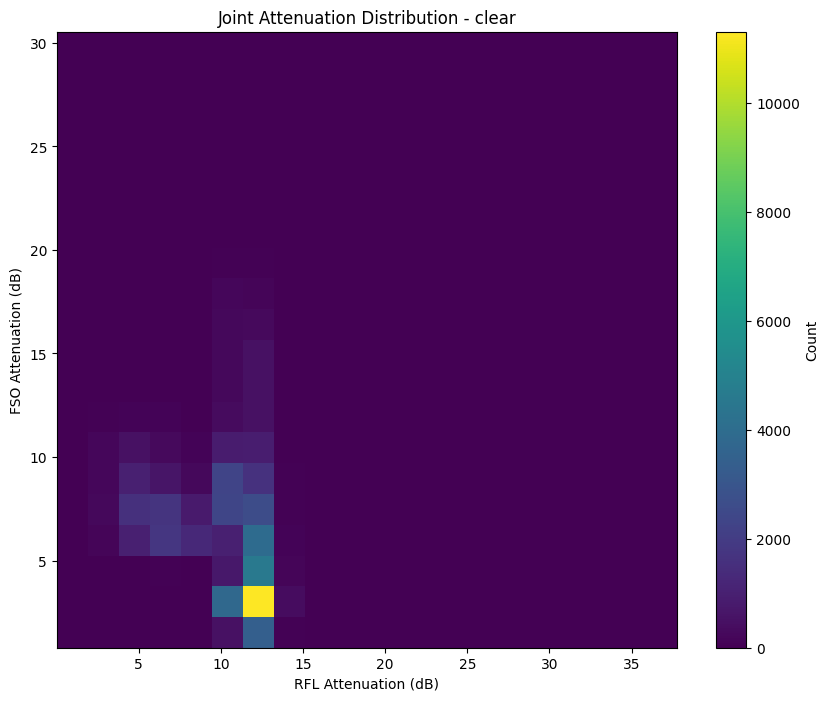

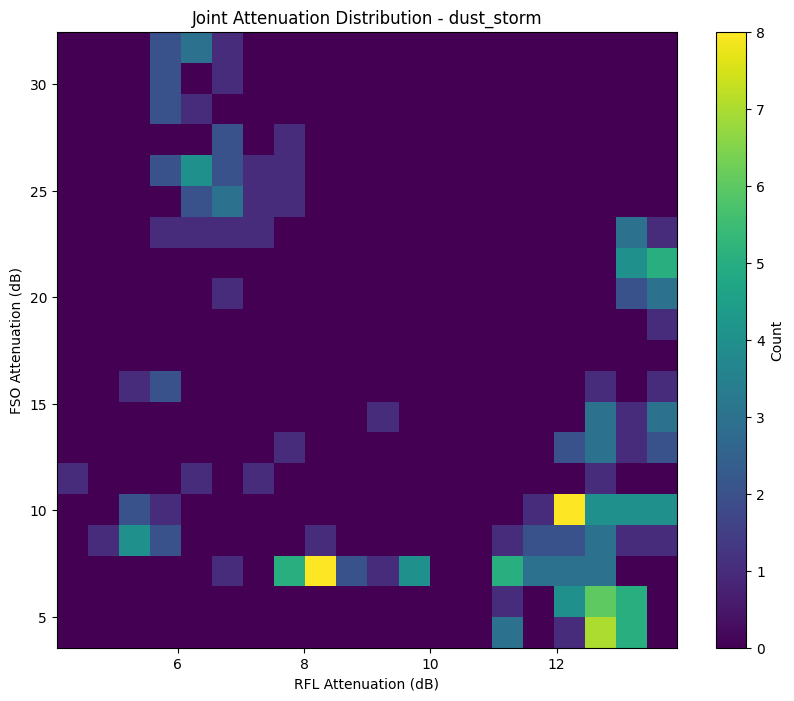

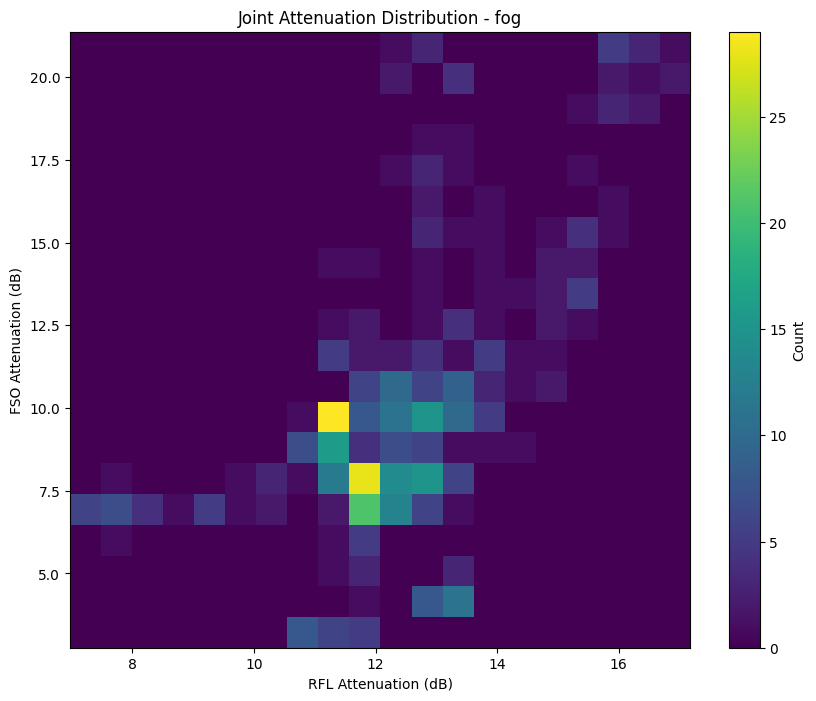

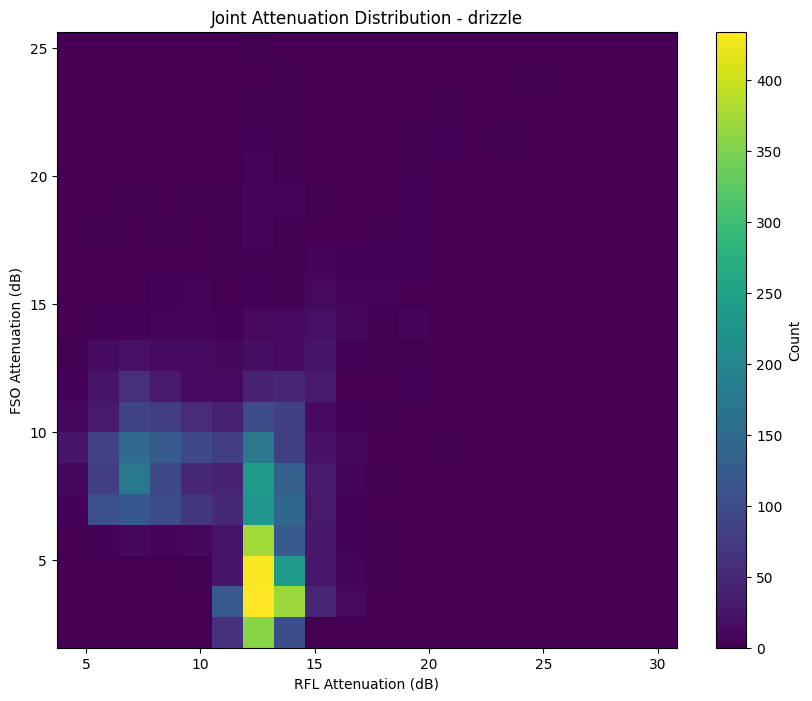

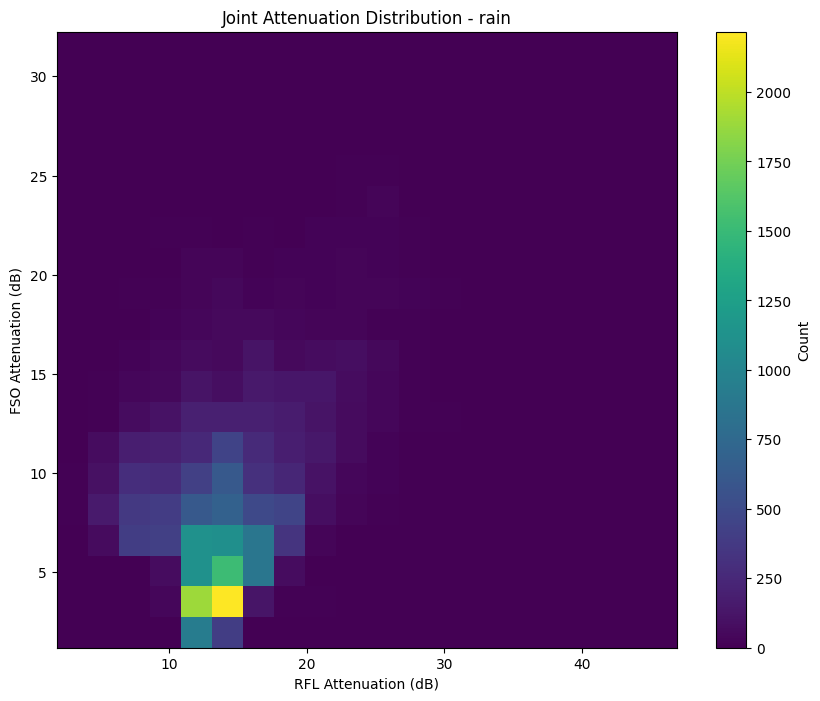

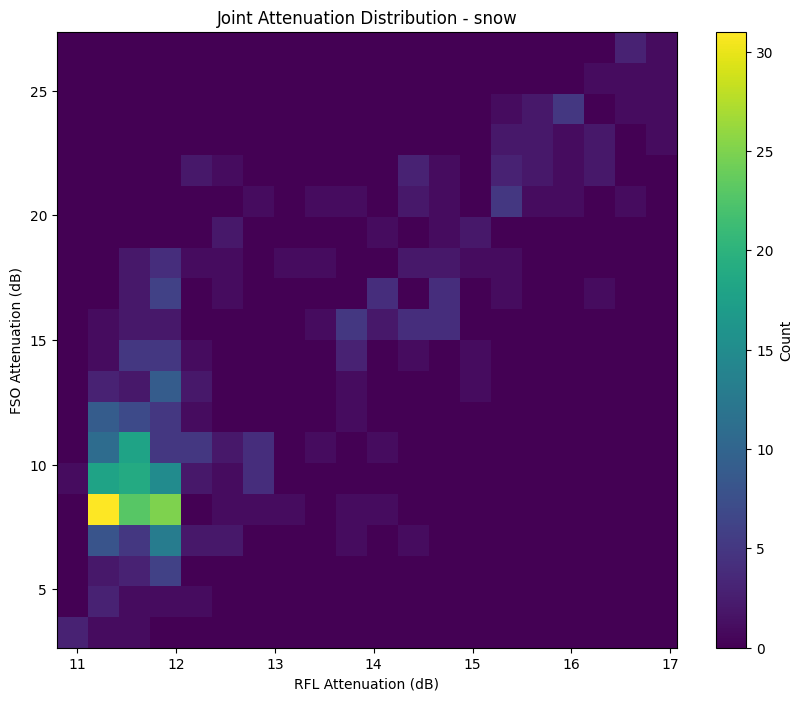

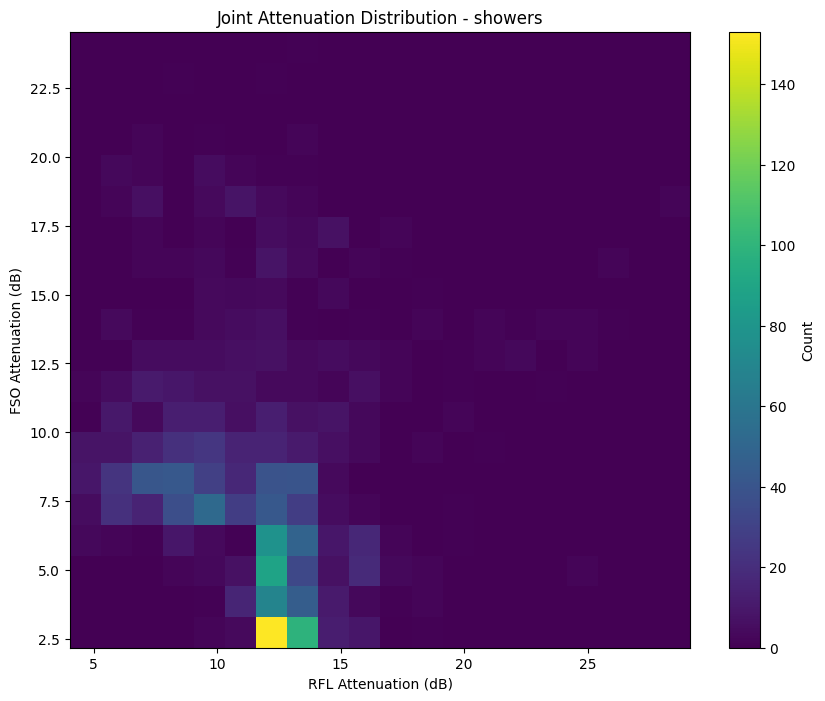

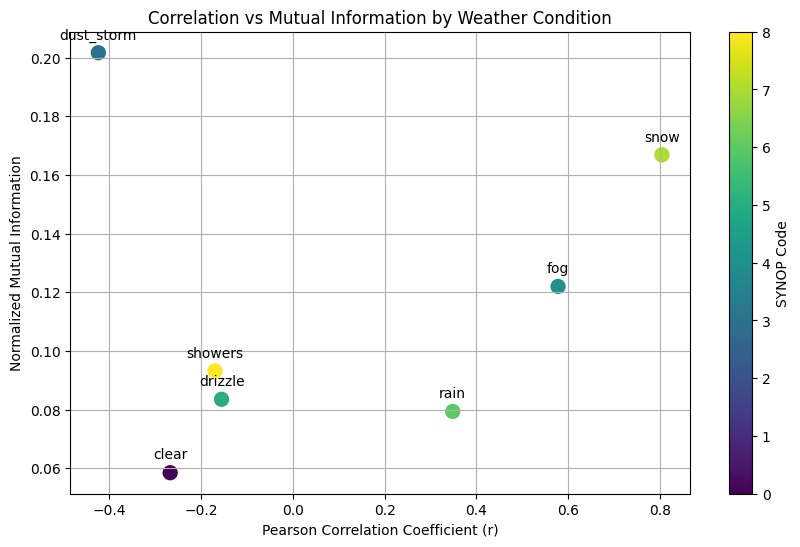

In [ ]:
def calculate_mutual_info(rfl_att, fso_att, bins=10):

    rfl_discrete = np.digitize(rfl_att, bins=np.histogram_bin_edges(rfl_att, bins=bins))
    fso_discrete = np.digitize(fso_att, bins=np.histogram_bin_edges(fso_att, bins=bins))
    mi = mutual_info_score(rfl_discrete, fso_discrete)

    h_rfl = mutual_info_score(rfl_discrete, rfl_discrete)
    h_fso = mutual_info_score(fso_discrete, fso_discrete)
    h_joint = h_rfl + h_fso - mi

    normalized_mi = mi / h_joint if h_joint > 0 else 0

    return mi, normalized_mi

def analyze_correlations(train_data, test_data, synop_values, categories):
    results = []

    for synop, weather in zip(synop_values, categories):
        train_subset = train_data[train_data['SYNOPCode'] == synop]
        test_subset = test_data[test_data['SYNOPCode'] == synop]

        if len(train_subset) == 0 and len(test_subset) == 0:
            continue
        combined = pd.concat([train_subset, test_subset])
        rfl_att = combined['RFL_Att'].values
        fso_att = combined['FSO_Att'].values

        if len(rfl_att) < 2 or len(fso_att) < 2:
            continue
        corr, p_value = pearsonr(rfl_att, fso_att)
        mi, normalized_mi = calculate_mutual_info(rfl_att, fso_att)

        results.append({
            'SYNOPCode': synop,
            'Weather': weather,
            'Pearson_r': corr,
            'P_value': p_value,
            'Mutual_Info': mi,
            'Normalized_MI': normalized_mi,
            'Sample_Size': len(rfl_att)
        })

    return pd.DataFrame(results)

def plot_attenuation_heatmap(rfl_att, fso_att, weather_name, bins=20):
    plt.figure(figsize=(10, 8))

    heatmap, xedges, yedges = np.histogram2d(
        rfl_att, fso_att, bins=bins,
        range=[[min(rfl_att), max(rfl_att)], [min(fso_att), max(fso_att)]])
    plt.imshow(heatmap.T, origin='lower', aspect='auto',
              extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
              cmap='viridis')

    plt.colorbar(label='Count')
    plt.xlabel('RFL Attenuation (dB)')
    plt.ylabel('FSO Attenuation (dB)')
    plt.title(f'Joint Attenuation Distribution - {weather_name}')
    plt.grid(False)
    plt.show()

synop_values = [0, 3, 4, 5, 6, 7, 8]
categories = ['clear', 'dust_storm', 'fog', 'drizzle', 'rain', 'snow', 'showers']

correlation_results = analyze_correlations(train_data, test_data, synop_values, categories)
print("Correlation and Mutual Information Analysis:")
print(correlation_results)

for _, row in correlation_results.iterrows():
    if row['Sample_Size'] > 10:
        weather_data = pd.concat([train_data, test_data])
        weather_data = weather_data[weather_data['SYNOPCode'] == row['SYNOPCode']]

        plot_attenuation_heatmap(
            weather_data['RFL_Att'].values,
            weather_data['FSO_Att'].values,
            row['Weather']
        )
plt.figure(figsize=(10, 6))
plt.scatter(correlation_results['Pearson_r'], correlation_results['Normalized_MI'],
           c=correlation_results['SYNOPCode'], cmap='viridis', s=100)
plt.xlabel('Pearson Correlation Coefficient (r)')
plt.ylabel('Normalized Mutual Information')
plt.title('Correlation vs Mutual Information by Weather Condition')
plt.colorbar(label='SYNOP Code')
plt.grid(True)

for i, row in correlation_results.iterrows():
    plt.annotate(row['Weather'], (row['Pearson_r'], row['Normalized_MI']),
                textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

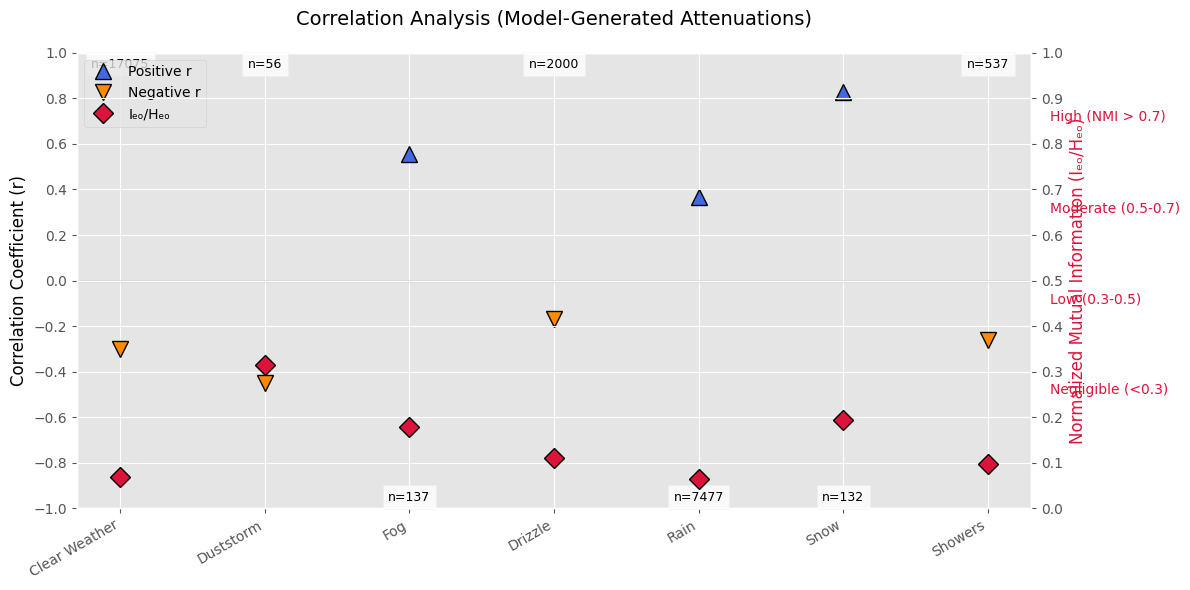

Model Performance Metrics:
         Weather      r    nmi  n_samples
0  Clear Weather -0.300  0.069      17075
1      Duststorm -0.450  0.315         56
2            Fog  0.555  0.180        137
3        Drizzle -0.168  0.111       2000
4           Rain  0.366  0.065       7477
5           Snow  0.828  0.193        132
6        Showers -0.262  0.098        537


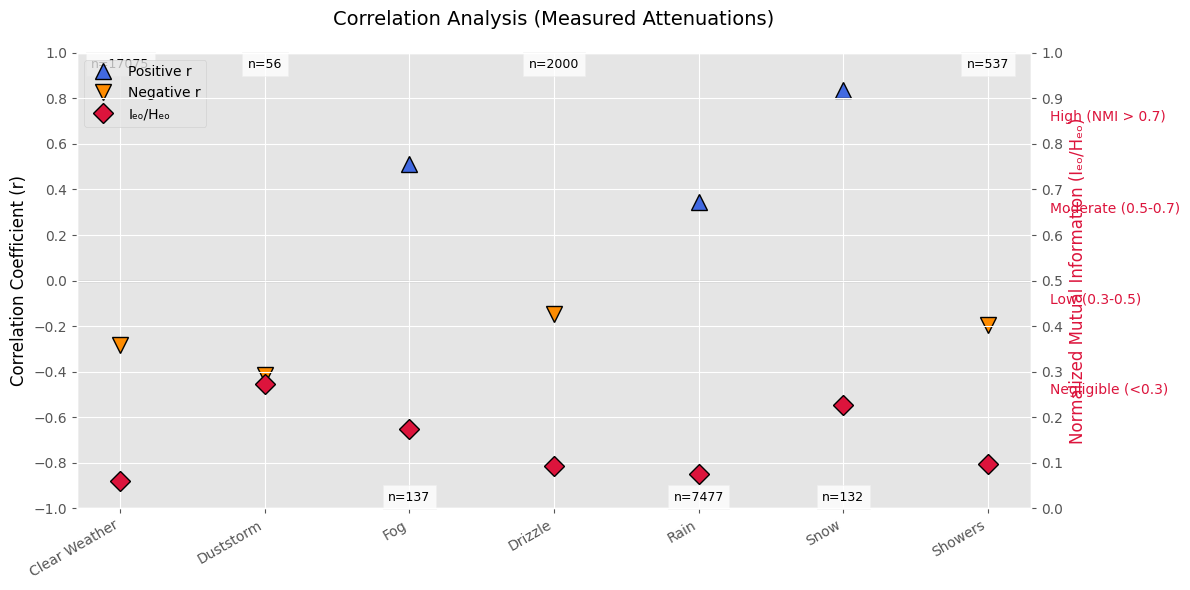


From Measured Attenuations
         Weather      r    nmi  n_samples
0  Clear Weather -0.282  0.060      17075
1      Duststorm -0.413  0.273         56
2            Fog  0.512  0.174        137
3        Drizzle -0.148  0.094       2000
4           Rain  0.346  0.075       7477
5           Snow  0.836  0.227        132
6        Showers -0.196  0.097        537


In [ ]:
def calculate_normalized_mi(x, y, bins=10):

    x_discrete = np.digitize(x, bins=np.histogram_bin_edges(x, bins=bins))
    y_discrete = np.digitize(y, bins=np.histogram_bin_edges(y, bins=bins))
    mi = mutual_info_score(x_discrete, y_discrete)

    h_x = mutual_info_score(x_discrete, x_discrete)
    h_y = mutual_info_score(y_discrete, y_discrete)
    h_joint = h_x + h_y - mi

    return mi / h_joint if h_joint > 0 else 0

def calculate_metrics(test_data, rf_pred, fso_pred, synop_values, categories):
    results = []
    for synop, weather in zip(synop_values, categories):
        mask = test_data['SYNOPCode'] == synop
        n_samples = sum(mask)
        if n_samples < 2:
            print(f"Warning: Not enough samples for weather condition {weather} (n={n_samples}). Skipping...")
            results.append({'Weather': weather, 'r': np.nan, 'nmi': np.nan, 'n_samples': n_samples})
            continue

        r, _ = pearsonr(rf_pred[mask], fso_pred[mask])
        nmi = calculate_normalized_mi(rf_pred[mask], fso_pred[mask])

        results.append({
            'Weather': weather,
            'r': r,
            'nmi': nmi,
            'n_samples': n_samples
        })
    return pd.DataFrame(results)

def plot_results(results_df, title_suffix=""):

    available_styles = plt.style.available
    preferred_styles = ['seaborn', 'ggplot', 'classic']
    for style in preferred_styles:
        if style in available_styles:
            plt.style.use(style)
            break

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_ylabel("Correlation Coefficient (r)", color='black', fontsize=12)
    ax1.set_ylim(-1, 1)
    ax1.set_xticks(range(len(results_df)))
    ax1.set_xticklabels(results_df['Weather'], rotation=30, ha='right')
    ax1.set_yticks(np.arange(-1, 1.1, 0.2))
    ax1.grid(axis='y', alpha=0.3)
    ax1.axhline(0, color='black', linewidth=0.8)

    pos_marker, neg_marker = None, None
    for i, row in results_df.iterrows():
        if pd.notna(row['r']):
            if row['r'] >= 0:
                pos_marker = ax1.plot(i, row['r'], '^', color='royalblue',
                                    markersize=12, markeredgecolor='black',
                                    label='Positive r' if i == 0 else "")[0]
            else:
                neg_marker = ax1.plot(i, row['r'], 'v', color='darkorange',
                                    markersize=12, markeredgecolor='black',
                                    label='Negative r' if i == 0 else "")[0]

    ax2 = ax1.twinx()
    ax2.set_ylabel("Normalized Mutual Information (Iₑₒ/Hₑₒ)", color='crimson', fontsize=12)
    ax2.set_ylim(0, 1)
    ax2.set_yticks(np.arange(0, 1.1, 0.1))

    nmi_marker = None
    for i, row in results_df.iterrows():
        if pd.notna(row['nmi']):
            nmi_marker = ax2.plot(i, row['nmi'], 'D', color='crimson',
                                markersize=10, markeredgecolor='black',
                                label='Iₑₒ/Hₑₒ' if i == 0 else "")[0]

    ax2.text(1.02, 0.85, 'High (NMI > 0.7)', color='crimson', transform=ax2.transAxes, fontsize=10)
    ax2.text(1.02, 0.65, 'Moderate (0.5-0.7)', color='crimson', transform=ax2.transAxes, fontsize=10)
    ax2.text(1.02, 0.45, 'Low (0.3-0.5)', color='crimson', transform=ax2.transAxes, fontsize=10)
    ax2.text(1.02, 0.25, 'Negligible (<0.3)', color='crimson', transform=ax2.transAxes, fontsize=10)

    for i, row in results_df.iterrows():
        if pd.notna(row['r']):
            ax1.text(i, -0.95 if row['r'] > 0 else 0.95,
                    f'n={row["n_samples"]}',
                    ha='center', va='center', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))
    handles = []
    labels = []
    if pos_marker:
        handles.append(pos_marker)
        labels.append('Positive r')
    if neg_marker:
        handles.append(neg_marker)
        labels.append('Negative r')
    if nmi_marker:
        handles.append(nmi_marker)
        labels.append('Iₑₒ/Hₑₒ')

    ax1.legend(handles, labels, loc='upper left', fontsize=10)

    plt.title(f"Correlation Analysis {title_suffix}", pad=20, fontsize=14)
    plt.tight_layout()
    plt.show()

synop_values = [0, 3, 4, 5, 6, 7, 8]
categories = ['Clear Weather', 'Duststorm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']

results_df = calculate_metrics(
    test_data,
    rf_att_pred_test,
    fso_att_pred,
    synop_values,
    categories
)

plot_results(results_df, title_suffix="(Model-Generated Attenuations)")

print("Model Performance Metrics:")
print(results_df[['Weather', 'r', 'nmi', 'n_samples']].round(3))

test_data['Weather'] = test_data['SYNOPCode'].map(dict(zip(synop_values, categories)))

results_df_measured = calculate_metrics(
    test_data=test_data,
    rf_pred=measured_rfl_att,
    fso_pred=measured_fso_att,
    synop_values=synop_values,
    categories=categories
)

plot_results(results_df_measured, title_suffix="(Measured Attenuations)")

print("\nFrom Measured Attenuations")
print(results_df_measured[['Weather', 'r', 'nmi', 'n_samples']].round(3))